In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import datetime
import re

df_weather = pd.read_csv("homeB2014.csv")

In [2]:
df_meter = pd.read_csv("HomeB-meter1_2014.csv")

In [3]:
df_weather.shape

(8760, 14)

In [4]:
df_meter.shape

(17520, 18)

In [5]:
#reducing the memory usage before using the dataframes for plotting and modelling
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
df_weather = reduce_mem_usage(df_weather)

Mem. usage decreased to  0.35 Mb (62.5% reduction)


In [7]:
df_meter = reduce_mem_usage(df_meter)

Mem. usage decreased to  0.70 Mb (70.8% reduction)


In [7]:
df_weather.head(5)

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,20.312500,clear-night,0.469971,10.0,Clear,7.738281,1023.0,12.648438,0.0,1388552400,283,0.0,3.300781,0.0
1,19.218750,clear-night,0.479980,10.0,Clear,7.890625,1023.0,9.992188,0.0,1388556000,283,0.0,2.689453,0.0
2,18.093750,clear-night,0.520020,10.0,Clear,8.109375,1024.0,7.761719,0.0,1388559600,255,0.0,3.419922,0.0
3,17.468750,clear-night,0.549805,10.0,Clear,7.359375,1025.0,7.730469,0.0,1388563200,245,0.0,4.000000,0.0
4,15.632812,clear-night,0.609863,10.0,Clear,6.980469,1025.0,5.761719,0.0,1388566800,220,0.0,4.449219,0.0


In [31]:
df_meter.head(5)

,Date & Time,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
0,2014-01-01 00:00:00,0.304443,0.0,0.304443,0.000058,0.009529,0.005337,0.000126,0.011177,0.003836,0.004837,0.002132,0.000009,0.007160,0.063660,0.004299,0.004734,0.042603
1,2014-01-01 00:30:00,0.656738,0.0,0.656738,0.001534,0.364258,0.005524,0.000043,0.003515,0.003511,0.004887,0.002136,0.000107,0.007221,0.064697,0.003590,0.004444,0.096008
2,2014-01-01 01:00:00,0.612793,0.0,0.612793,0.001846,0.417969,0.005505,0.000044,0.003529,0.003485,0.004929,0.002052,0.000170,0.007198,0.065125,0.003521,0.004395,0.025925
3,2014-01-01 01:30:00,0.684082,0.0,0.684082,0.001744,0.410645,0.005558,0.000059,0.003498,0.003475,0.004910,0.002068,0.000121,0.007236,0.065002,0.003405,0.004261,0.105469
4,2014-01-01 02:00:00,0.197754,0.0,0.197754,0.000030,0.017151,0.005302,0.000119,0.003695,0.003864,0.004875,0.002087,0.000052,0.007133,0.062439,0.003914,0.004406,0.016800


In [8]:
df_weather = df_weather.drop(['icon', 'summary'], axis=1)

In [9]:
df_meter = df_meter.drop(['gen [kW]', 'Grid [kW]'], axis=1)

In [10]:
df_weather.head(5)

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,20.312500,0.469971,10.0,7.738281,1023.0,12.648438,0.0,1388552400,283,0.0,3.300781,0.0
1,19.218750,0.479980,10.0,7.890625,1023.0,9.992188,0.0,1388556000,283,0.0,2.689453,0.0
2,18.093750,0.520020,10.0,8.109375,1024.0,7.761719,0.0,1388559600,255,0.0,3.419922,0.0
3,17.468750,0.549805,10.0,7.359375,1025.0,7.730469,0.0,1388563200,245,0.0,4.000000,0.0
4,15.632812,0.609863,10.0,6.980469,1025.0,5.761719,0.0,1388566800,220,0.0,4.449219,0.0


In [10]:
df_weather['Date & Time'] = pd.to_datetime(df_weather['time'], unit='s')

In [12]:
df_weather.head(5)

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability,Date & Time
0,20.312500,0.469971,10.0,7.738281,1023.0,12.648438,0.0,1388552400,283,0.0,3.300781,0.0,2014-01-01 05:00:00
1,19.218750,0.479980,10.0,7.890625,1023.0,9.992188,0.0,1388556000,283,0.0,2.689453,0.0,2014-01-01 06:00:00
2,18.093750,0.520020,10.0,8.109375,1024.0,7.761719,0.0,1388559600,255,0.0,3.419922,0.0,2014-01-01 07:00:00
3,17.468750,0.549805,10.0,7.359375,1025.0,7.730469,0.0,1388563200,245,0.0,4.000000,0.0,2014-01-01 08:00:00
4,15.632812,0.609863,10.0,6.980469,1025.0,5.761719,0.0,1388566800,220,0.0,4.449219,0.0,2014-01-01 09:00:00


In [11]:
df_weather['Date & Time'] = df_weather['Date & Time'] - pd.Timedelta(hours=5)

In [14]:
df_weather.head(5)

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability,Date & Time
0,20.312500,0.469971,10.0,7.738281,1023.0,12.648438,0.0,1388552400,283,0.0,3.300781,0.0,2014-01-01 00:00:00
1,19.218750,0.479980,10.0,7.890625,1023.0,9.992188,0.0,1388556000,283,0.0,2.689453,0.0,2014-01-01 01:00:00
2,18.093750,0.520020,10.0,8.109375,1024.0,7.761719,0.0,1388559600,255,0.0,3.419922,0.0,2014-01-01 02:00:00
3,17.468750,0.549805,10.0,7.359375,1025.0,7.730469,0.0,1388563200,245,0.0,4.000000,0.0,2014-01-01 03:00:00
4,15.632812,0.609863,10.0,6.980469,1025.0,5.761719,0.0,1388566800,220,0.0,4.449219,0.0,2014-01-01 04:00:00


In [33]:
df_meter.dtypes

Date & Time                         object
use [kW]                           float16
AC [kW]                            float16
Furnace [kW]                       float16
Cellar Lights [kW]                 float16
Washer [kW]                        float16
First Floor lights [kW]            float16
Utility Rm + Basement Bath [kW]    float16
Garage outlets [kW]                float16
MBed + KBed outlets [kW]           float16
Dryer + egauge [kW]                float16
Panel GFI (central vac) [kW]       float16
Home Office (R) [kW]               float16
Dining room (R) [kW]               float16
Microwave (R) [kW]                 float16
Fridge (R) [kW]                    float16
dtype: object

In [12]:
df_meter['Date & Time'] = pd.to_datetime(df_meter['Date & Time'])

In [36]:
df_meter.head(5)

,Date & Time,use [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
0,2014-01-01 00:00:00,0.304443,0.000058,0.009529,0.005337,0.000126,0.011177,0.003836,0.004837,0.002132,0.000009,0.007160,0.063660,0.004299,0.004734,0.042603
1,2014-01-01 00:30:00,0.656738,0.001534,0.364258,0.005524,0.000043,0.003515,0.003511,0.004887,0.002136,0.000107,0.007221,0.064697,0.003590,0.004444,0.096008
2,2014-01-01 01:00:00,0.612793,0.001846,0.417969,0.005505,0.000044,0.003529,0.003485,0.004929,0.002052,0.000170,0.007198,0.065125,0.003521,0.004395,0.025925
3,2014-01-01 01:30:00,0.684082,0.001744,0.410645,0.005558,0.000059,0.003498,0.003475,0.004910,0.002068,0.000121,0.007236,0.065002,0.003405,0.004261,0.105469
4,2014-01-01 02:00:00,0.197754,0.000030,0.017151,0.005302,0.000119,0.003695,0.003864,0.004875,0.002087,0.000052,0.007133,0.062439,0.003914,0.004406,0.016800


In [13]:
df_meter = df_meter.resample('H', on='Date & Time').mean()

In [14]:
df_meter.shape

(8760, 15)

In [15]:
df_weather.shape

(8760, 13)

In [40]:
df_meter.head(5)

,use [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
Date & Time,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.480469,0.000796,0.186890,0.005432,0.000084,0.007347,0.003674,0.004860,0.002134,0.000058,0.007191,0.064209,0.003944,0.004589,0.069336
2014-01-01 01:00:00,0.648438,0.001795,0.414307,0.005531,0.000052,0.003513,0.003479,0.004921,0.002060,0.000146,0.007217,0.065063,0.003464,0.004326,0.065674
2014-01-01 02:00:00,0.297363,0.000236,0.072021,0.005360,0.000087,0.003660,0.003807,0.004883,0.002110,0.000038,0.007160,0.063110,0.003864,0.004402,0.061737
2014-01-01 03:00:00,0.564453,0.001465,0.338867,0.005508,0.000032,0.003572,0.003546,0.004921,0.002104,0.000122,0.007202,0.064209,0.003574,0.004288,0.063782
2014-01-01 04:00:00,0.421387,0.000859,0.198608,0.005424,0.000087,0.003620,0.003651,0.004868,0.002098,0.000076,0.007156,0.067261,0.003937,0.004448,0.057922


In [14]:
df_merge = pd.merge(df_meter, df_weather, left_on=['Date & Time'], right_on = ['Date & Time'], how='left')

In [15]:
df_merge.head()

,Date & Time,use [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],...,visibility,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 00:00:00,0.480469,0.000796,0.186890,0.005432,0.000084,0.007347,0.003674,0.004860,0.002134,...,10.0,7.738281,1023.0,12.648438,0.0,1388552400,283,0.0,3.300781,0.0
1,2014-01-01 01:00:00,0.648438,0.001795,0.414307,0.005531,0.000052,0.003513,0.003479,0.004921,0.002060,...,10.0,7.890625,1023.0,9.992188,0.0,1388556000,283,0.0,2.689453,0.0
2,2014-01-01 02:00:00,0.297363,0.000236,0.072021,0.005360,0.000087,0.003660,0.003807,0.004883,0.002110,...,10.0,8.109375,1024.0,7.761719,0.0,1388559600,255,0.0,3.419922,0.0
3,2014-01-01 03:00:00,0.564453,0.001465,0.338867,0.005508,0.000032,0.003572,0.003546,0.004921,0.002104,...,10.0,7.359375,1025.0,7.730469,0.0,1388563200,245,0.0,4.000000,0.0
4,2014-01-01 04:00:00,0.421387,0.000859,0.198608,0.005424,0.000087,0.003620,0.003651,0.004868,0.002098,...,10.0,6.980469,1025.0,5.761719,0.0,1388566800,220,0.0,4.449219,0.0


In [43]:
#df_merge = df_merge.drop(['time'], axis=1)

In [15]:
df_merge_backup = df_merge
#del df_meter,df_weather

In [16]:
df_merge.index = df_merge['Date & Time']

In [17]:
df_merge = df_merge.drop(['Date & Time', 'time'], axis=1)

In [18]:
#Removing [] from column names and replacing them with _ as XGBoost doesn't allow such names
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

df_merge.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_merge.columns]

In [19]:
comb_df = df_merge

In [20]:
comb_df['pressure_log'] = comb_df['pressure'].apply(np.log)

In [21]:
comb_df = comb_df.dropna()

In [22]:
pd.set_option('display.max_columns', None)
comb_df.head(5)

,use _kW_,AC _kW_,Furnace _kW_,Cellar Lights _kW_,Washer _kW_,First Floor lights _kW_,Utility Rm + Basement Bath _kW_,Garage outlets _kW_,MBed + KBed outlets _kW_,Dryer + egauge _kW_,Panel GFI (central vac) _kW_,Home Office (R) _kW_,Dining room (R) _kW_,Microwave (R) _kW_,Fridge (R) _kW_,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,pressure_log
Date & Time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.480469,0.000796,0.186890,0.005432,0.000084,0.007347,0.003674,0.004860,0.002134,0.000058,0.007191,0.064209,0.003944,0.004589,0.069336,20.312500,0.469971,10.0,7.738281,1023.0,12.648438,0.0,283,0.0,3.300781,0.0,6.929688
2014-01-01 01:00:00,0.648438,0.001795,0.414307,0.005531,0.000052,0.003513,0.003479,0.004921,0.002060,0.000146,0.007217,0.065063,0.003464,0.004326,0.065674,19.218750,0.479980,10.0,7.890625,1023.0,9.992188,0.0,283,0.0,2.689453,0.0,6.929688
2014-01-01 02:00:00,0.297363,0.000236,0.072021,0.005360,0.000087,0.003660,0.003807,0.004883,0.002110,0.000038,0.007160,0.063110,0.003864,0.004402,0.061737,18.093750,0.520020,10.0,8.109375,1024.0,7.761719,0.0,255,0.0,3.419922,0.0,6.929688
2014-01-01 03:00:00,0.564453,0.001465,0.338867,0.005508,0.000032,0.003572,0.003546,0.004921,0.002104,0.000122,0.007202,0.064209,0.003574,0.004288,0.063782,17.468750,0.549805,10.0,7.359375,1025.0,7.730469,0.0,245,0.0,4.000000,0.0,6.933594
2014-01-01 04:00:00,0.421387,0.000859,0.198608,0.005424,0.000087,0.003620,0.003651,0.004868,0.002098,0.000076,0.007156,0.067261,0.003937,0.004448,0.057922,15.632812,0.609863,10.0,6.980469,1025.0,5.761719,0.0,220,0.0,4.449219,0.0,6.933594


In [23]:
final_df = (comb_df.assign( day_of_week = comb_df.index.dayofweek,month = comb_df.index.month
                            ,day = comb_df.index.day,day_of_year = comb_df.index.dayofyear,week = comb_df.index.week
                            ,quarter = comb_df.index.quarter,hour = comb_df.index.hour
                            ,hour_x = np.sin(2.*np.pi*comb_df.index.hour/24.),hour_y = np.cos(2*np.pi*comb_df.index.hour/24.)
                            ,day_of_year_x = np.sin(2.*np.pi*comb_df.index.dayofyear/365.)
                            ,day_of_year_y = np.cos(2.*np.pi*comb_df.index.dayofyear/365.)))

In [39]:
final_df.head()

,use _kW_,AC _kW_,Furnace _kW_,Cellar Lights _kW_,Washer _kW_,First Floor lights _kW_,Utility Rm + Basement Bath _kW_,Garage outlets _kW_,MBed + KBed outlets _kW_,Dryer + egauge _kW_,Panel GFI (central vac) _kW_,Home Office (R) _kW_,Dining room (R) _kW_,Microwave (R) _kW_,Fridge (R) _kW_,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,pressure_log,day_of_week,month,day,day_of_year,week,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Date & Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.480469,0.000796,0.186890,0.005432,0.000084,0.007347,0.003674,0.004860,0.002134,0.000058,0.007191,0.064209,0.003944,0.004589,0.069336,20.312500,0.469971,10.0,7.738281,1023.0,12.648438,0.0,283,0.0,3.300781,0.0,6.929688,2,1,1,1,1,1,0,0.000000,1.000000,0.017213,0.999852
2014-01-01 01:00:00,0.648438,0.001795,0.414307,0.005531,0.000052,0.003513,0.003479,0.004921,0.002060,0.000146,0.007217,0.065063,0.003464,0.004326,0.065674,19.218750,0.479980,10.0,7.890625,1023.0,9.992188,0.0,283,0.0,2.689453,0.0,6.929688,2,1,1,1,1,1,1,0.258819,0.965926,0.017213,0.999852
2014-01-01 02:00:00,0.297363,0.000236,0.072021,0.005360,0.000087,0.003660,0.003807,0.004883,0.002110,0.000038,0.007160,0.063110,0.003864,0.004402,0.061737,18.093750,0.520020,10.0,8.109375,1024.0,7.761719,0.0,255,0.0,3.419922,0.0,6.929688,2,1,1,1,1,1,2,0.500000,0.866025,0.017213,0.999852
2014-01-01 03:00:00,0.564453,0.001465,0.338867,0.005508,0.000032,0.003572,0.003546,0.004921,0.002104,0.000122,0.007202,0.064209,0.003574,0.004288,0.063782,17.468750,0.549805,10.0,7.359375,1025.0,7.730469,0.0,245,0.0,4.000000,0.0,6.933594,2,1,1,1,1,1,3,0.707107,0.707107,0.017213,0.999852
2014-01-01 04:00:00,0.421387,0.000859,0.198608,0.005424,0.000087,0.003620,0.003651,0.004868,0.002098,0.000076,0.007156,0.067261,0.003937,0.004448,0.057922,15.632812,0.609863,10.0,6.980469,1025.0,5.761719,0.0,220,0.0,4.449219,0.0,6.933594,2,1,1,1,1,1,4,0.866025,0.500000,0.017213,0.999852


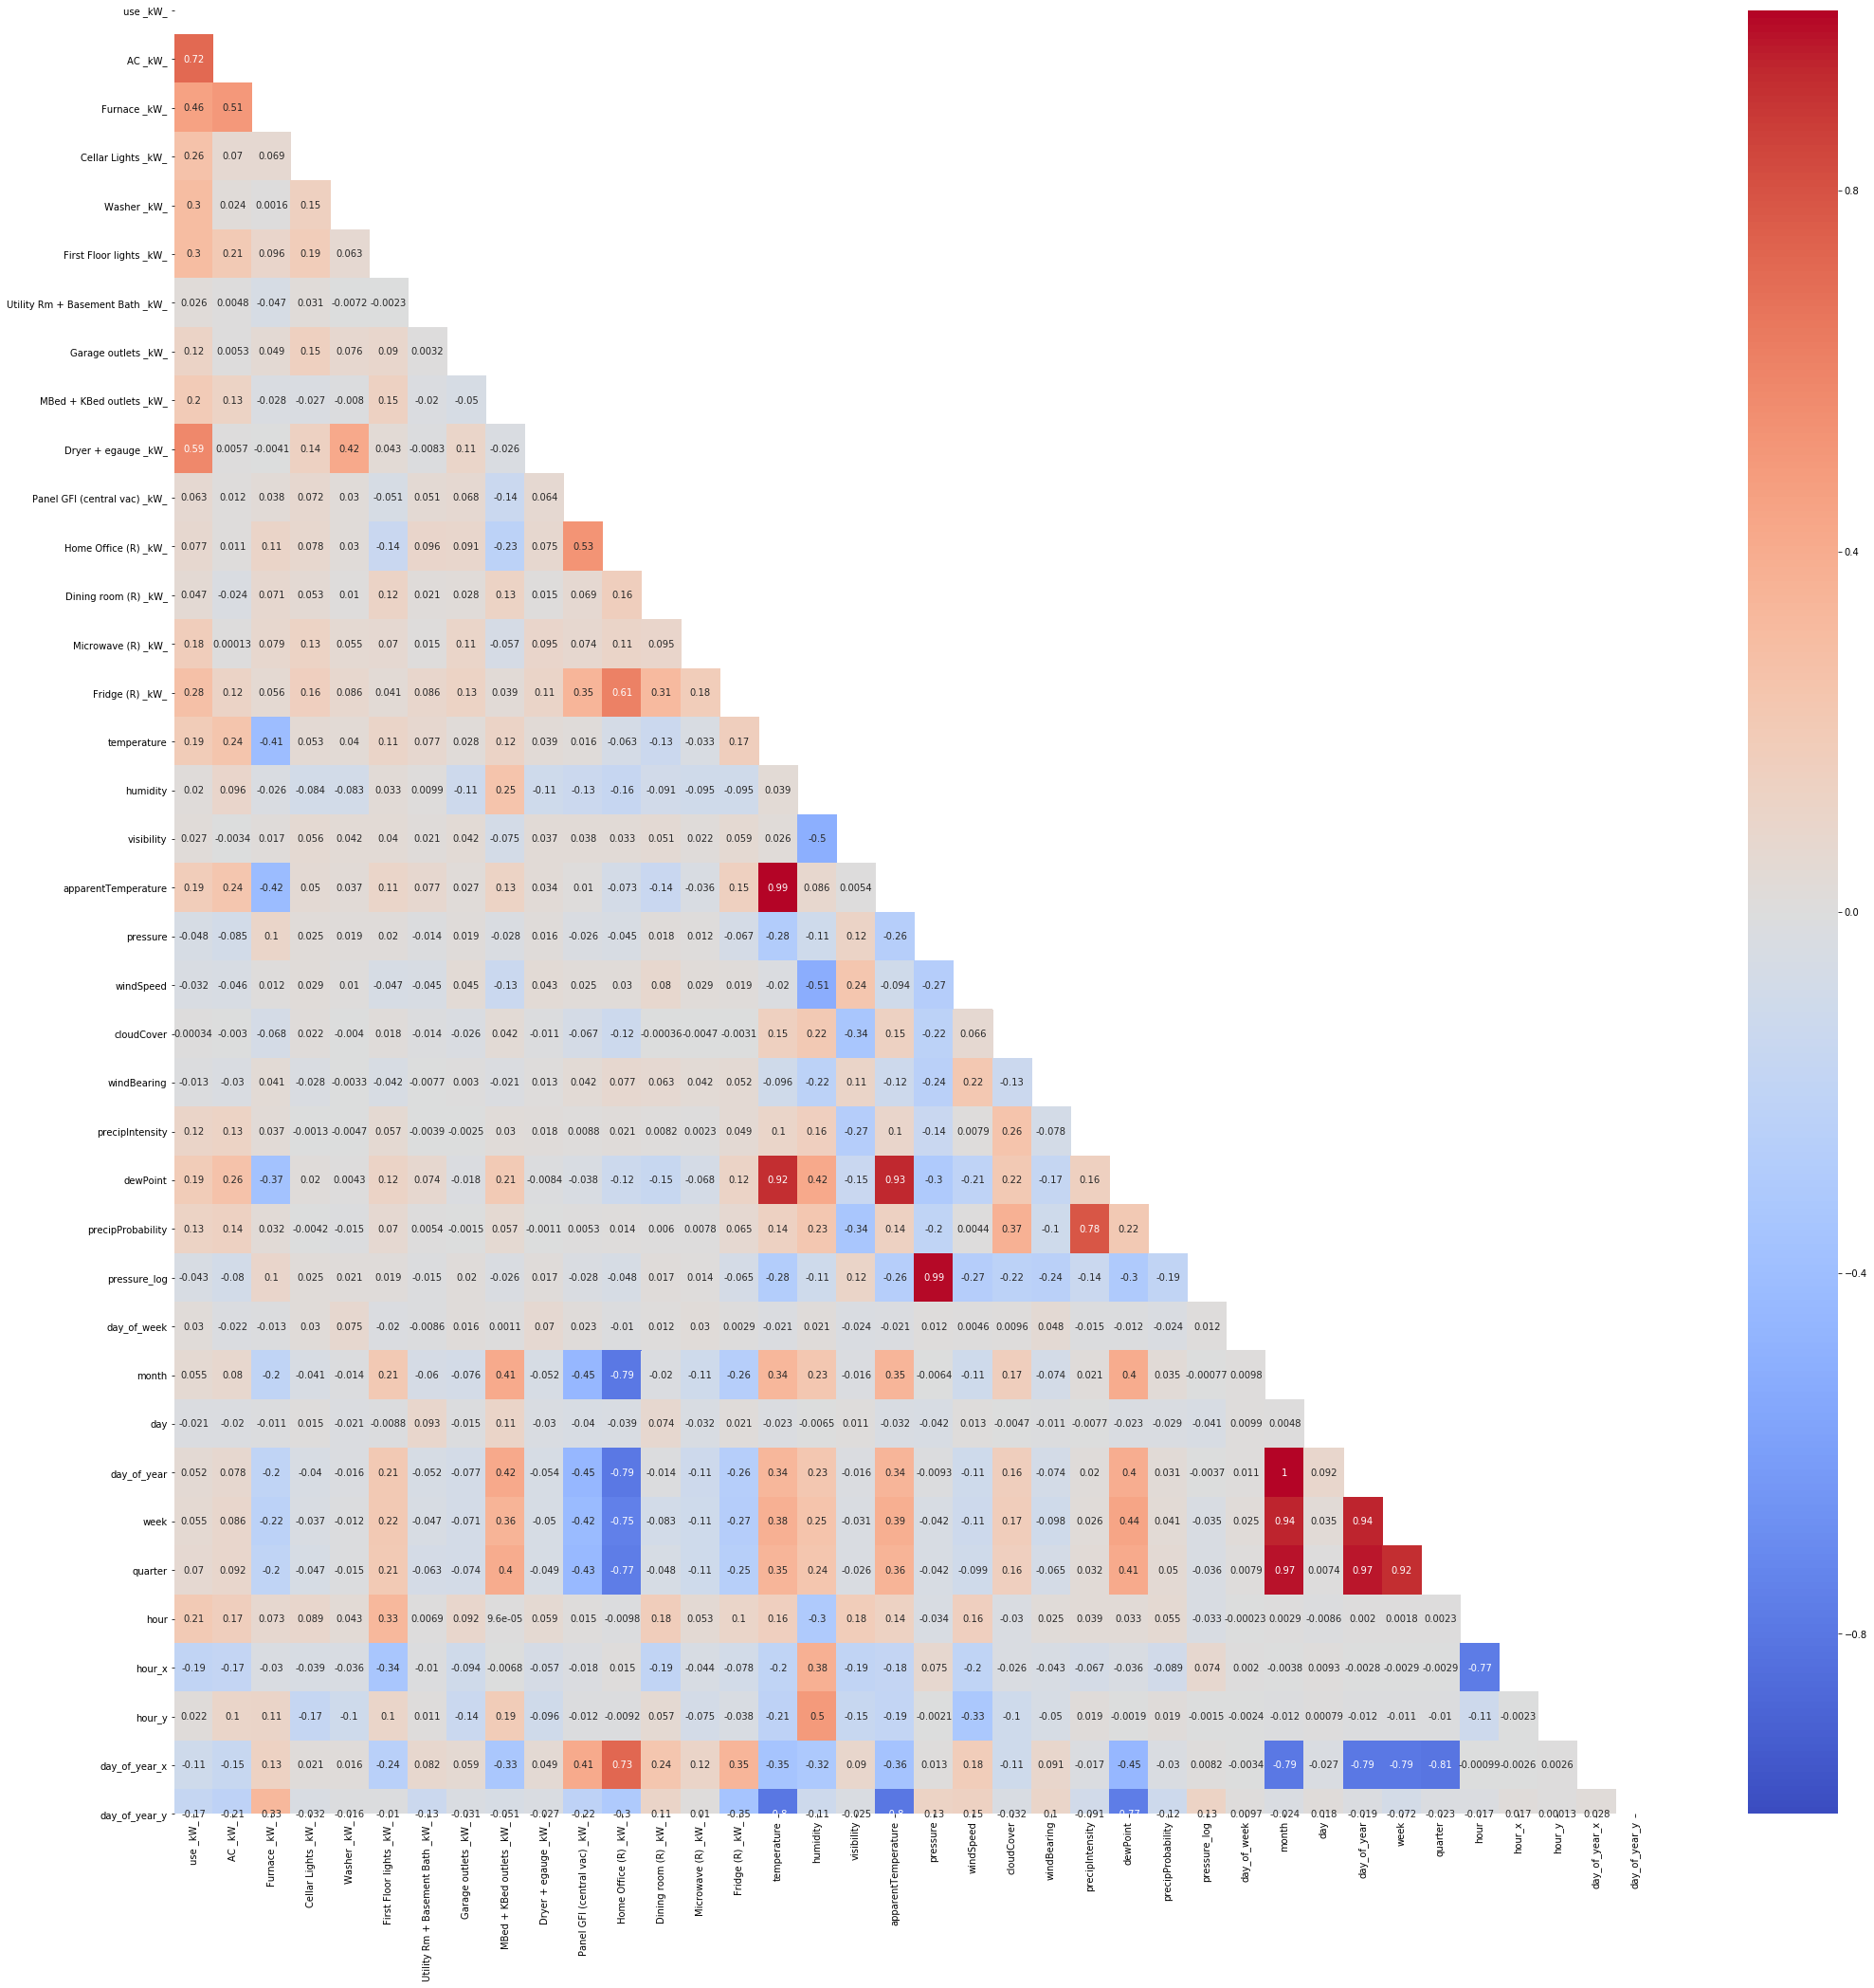

In [24]:
corr = final_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(35,35))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, mask = mask, vmin=-1)

In [25]:
#Removing apparentTemperature since it has high correlation with temperature and both convey same info
final_df = final_df.drop(['apparentTemperature'], axis=1)

In [26]:
#Removing apparentTemperature since it has high correlation with temperature and both convey same info
comb_df = comb_df.drop(['apparentTemperature'], axis=1)

In [16]:
#df_merge["weekday"] = df_merge["Date & Time"].dt.weekday
#df_merge["hour"] = df_merge["Date & Time"].dt.hour
#df_merge['dayofweek'] = df_merge['Date & Time'].dt.dayofweek
#df_merge['quarter'] = df_merge['Date & Time'].dt.quarter
#df_merge['month'] = df_merge['Date & Time'].dt.month
#df_merge['dayofyear'] = df_merge['Date & Time'].dt.dayofyear
#df_merge['dayofmonth'] = df_merge['Date & Time'].dt.day
#df_merge['weekofyear'] = df_merge['Date & Time'].dt.weekofyear

In [27]:
total = final_df.isnull().sum().sort_values(ascending = False)
percent = (final_df.isnull().sum()/final_df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [30]:
missing__train_data

,Total,Percent
day_of_year_y,0,0.0
visibility,0,0.0
temperature,0,0.0
Fridge (R) _kW_,0,0.0
Microwave (R) _kW_,0,0.0
Dining room (R) _kW_,0,0.0
Home Office (R) _kW_,0,0.0
Panel GFI (central vac) _kW_,0,0.0
Dryer + egauge _kW_,0,0.0
MBed + KBed outlets _kW_,0,0.0


In [28]:
final_df = final_df.fillna(0)

In [29]:
weekly_summary = pd.DataFrame()
weekly_summary['visibility'] = df_merge.visibility.resample('W').mean()
weekly_summary['use [kW]'] = df_merge['use _kW_'].resample('W').sum()
#weekly_summary['cumulative_distance'] = df_merge.cumulative_distance.resample('W').last()

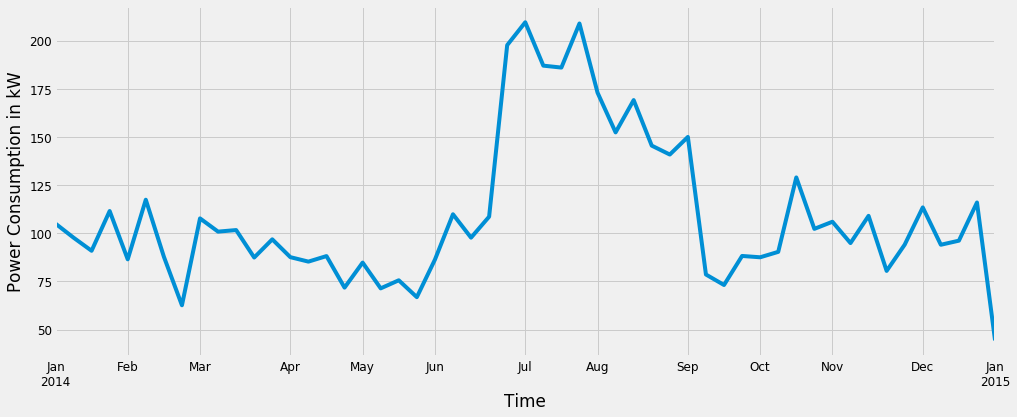

In [32]:
import warnings

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'


warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

ax = weekly_summary['use [kW]'].plot(figsize=(15, 6))
ax.set_xlabel('Time')
ax.set_ylabel('Power Consumption in kW')
plt.show()

In [30]:
df_final_backup_ = final_df

In [111]:
final_df.head(5)

,use _kW_,AC _kW_,Furnace _kW_,Cellar Lights _kW_,Washer _kW_,First Floor lights _kW_,Utility Rm + Basement Bath _kW_,Garage outlets _kW_,MBed + KBed outlets _kW_,Dryer + egauge _kW_,Panel GFI (central vac) _kW_,Home Office (R) _kW_,Dining room (R) _kW_,Microwave (R) _kW_,Fridge (R) _kW_,temperature,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,pressure_log,day_of_week,month,day,day_of_year,week,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Date & Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.480469,0.000796,0.186890,0.005432,0.000084,0.007347,0.003674,0.004860,0.002134,0.000058,0.007191,0.064209,0.003944,0.004589,0.069336,20.312500,0.469971,10.0,1023.0,12.648438,0.0,283,0.0,3.300781,0.0,6.929688,2,1,1,1,1,1,0,0.000000,1.000000,0.017213,0.999852
2014-01-01 01:00:00,0.648438,0.001795,0.414307,0.005531,0.000052,0.003513,0.003479,0.004921,0.002060,0.000146,0.007217,0.065063,0.003464,0.004326,0.065674,19.218750,0.479980,10.0,1023.0,9.992188,0.0,283,0.0,2.689453,0.0,6.929688,2,1,1,1,1,1,1,0.258819,0.965926,0.017213,0.999852
2014-01-01 02:00:00,0.297363,0.000236,0.072021,0.005360,0.000087,0.003660,0.003807,0.004883,0.002110,0.000038,0.007160,0.063110,0.003864,0.004402,0.061737,18.093750,0.520020,10.0,1024.0,7.761719,0.0,255,0.0,3.419922,0.0,6.929688,2,1,1,1,1,1,2,0.500000,0.866025,0.017213,0.999852
2014-01-01 03:00:00,0.564453,0.001465,0.338867,0.005508,0.000032,0.003572,0.003546,0.004921,0.002104,0.000122,0.007202,0.064209,0.003574,0.004288,0.063782,17.468750,0.549805,10.0,1025.0,7.730469,0.0,245,0.0,4.000000,0.0,6.933594,2,1,1,1,1,1,3,0.707107,0.707107,0.017213,0.999852
2014-01-01 04:00:00,0.421387,0.000859,0.198608,0.005424,0.000087,0.003620,0.003651,0.004868,0.002098,0.000076,0.007156,0.067261,0.003937,0.004448,0.057922,15.632812,0.609863,10.0,1025.0,5.761719,0.0,220,0.0,4.449219,0.0,6.933594,2,1,1,1,1,1,4,0.866025,0.500000,0.017213,0.999852


In [31]:
# Build lagged weather predictors.
# lagged_df = comb_df.loc[comb_df.index.min().ceil('D'):].copy()
lagged_df = final_df.copy()

# Next day's load values.
lagged_df['load_tomorrow'] = lagged_df['use _kW_'].shift(-24)    

for day in range(8):
    lagged_df['temperature_d' + str(day)] = lagged_df.temperature.shift(24*day)
    lagged_df['windSpeed_d' + str(day)] = lagged_df.windSpeed.shift(24*day)
    lagged_df['humidity_d' + str(day)] = lagged_df.humidity.shift(24*day)
    lagged_df['pressure_log_d' + str(day)] = lagged_df.pressure_log.shift(24*day)
    lagged_df['cloudCover_d' + str(day)] = lagged_df.cloudCover.shift(24*day)
    lagged_df['windBearing_d' + str(day)] = lagged_df.windBearing.shift(24*day)
    lagged_df['precipIntensity_d' + str(day)] = lagged_df.precipIntensity.shift(24*day)
    lagged_df['dewPoint_d' + str(day)] = lagged_df.dewPoint.shift(24*day)
    lagged_df['precipProbability_d' + str(day)] = lagged_df.precipProbability.shift(24*day)
    lagged_df['load_d' + str(day)] = lagged_df['use _kW_'].shift(24*day)

     
lagged_df = lagged_df.dropna()
    

lagged_df = lagged_df.drop(columns=['temperature', 'windSpeed', 'humidity', 'pressure', 'cloudCover',
                                    'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability','use _kW_'])

In [46]:
#lagged_df = final_df.copy()
#lagged_df['load_tomorrow'] = lagged_df['use _kW_'].shift(-24)
#lagged_df = lagged_df.dropna()
#lagged_df = lagged_df.drop(columns=['use _kW_'])

In [32]:
X = lagged_df.drop(columns=['load_tomorrow'])
y = lagged_df['load_tomorrow']

In [33]:
X.shape

(7097, 107)

In [34]:
y.shape

(7097,)

In [42]:
import numpy as np
import pandas as pd

from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

print('Building model...')
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return mean_absolute_error(y, y_pred)

def cv_rmse(model, X=X):
    rmse = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kfolds)
    return (rmse)

Building model...


In [37]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))  

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0004,))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=4, max_features='sqrt', min_samples_leaf=20, min_samples_split=10, loss='huber', random_state =42)                             

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.005, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=4060,
                                     max_depth=4, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00005)

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [43]:
#Store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'SVR': svr,
          'GBR': gbr,
          'LightGBM': lightgbm,
          'XGBoost': xgboost}
scores = {}

#Evaluating model score
print('Evaluating model scores...')
for name, model in models.items():    
    score = cv_rmse(model)
    print((name + ": {:.4f} ({:.4f})\n").format(score.mean(), score.std()))
    scores[name] = (score.mean(), score.std())
    
print('Done evaluating')

print('Fitting models...')

print('Fitting StackingRegressor...')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('Fitting ElasticNet...')
elastic_model_full_data = elasticnet.fit(X, y)

print('Fitting Lasso...')
lasso_model_full_data = lasso.fit(X, y)

print('Fitting Ridge...')
ridge_model_full_data = ridge.fit(X, y)

print('Fitting SVR...')
svr_model_full_data = svr.fit(X, y)

print('Fitting GradientBoosting...')
gbr_model_full_data = gbr.fit(X, y)

print('Fitting XGBoost...')
xgb_model_full_data = xgboost.fit(X, y)

print('Fitting LightGBM...')
lgb_model_full_data = lightgbm.fit(X, y)

print('Done fitting all models')

Evaluating model scores...
Ridge: 0.3383 (0.0188)

Lasso: 0.3389 (0.0180)

ElasticNet: 0.3389 (0.0180)

SVR: 0.3224 (0.0224)

GBR: 0.2565 (0.0192)

LightGBM: 0.3078 (0.0186)

[20:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:26:06] WARNING: /workspace/src/objective/regression_obj.cu:

In [150]:
#Blending model predictions
print('Blending model predictions...')
def blend_models_predict(X):
    return ((0.045 * elastic_model_full_data.predict(X)) +(0.05 * lasso_model_full_data.predict(X)) + (0.05 * ridge_model_full_data.predict(X)) + (0.1 * svr_model_full_data.predict(X)) + (0.15 * gbr_model_full_data.predict(X)) +(0.1 * xgb_model_full_data.predict(X)) + (0.1 * lgb_model_full_data.predict(X)) +(0.5 * stack_gen_model.predict(np.array(X))))

rmsle_score = rmsle(y, blend_models_predict(X))
print('MAE score on train data:' + str(rmsle_score))
scores['Blender'] = (rmsle_score.mean(), rmsle_score.std())

Blending model predictions...
MAE score on train data:0.15500701664520206


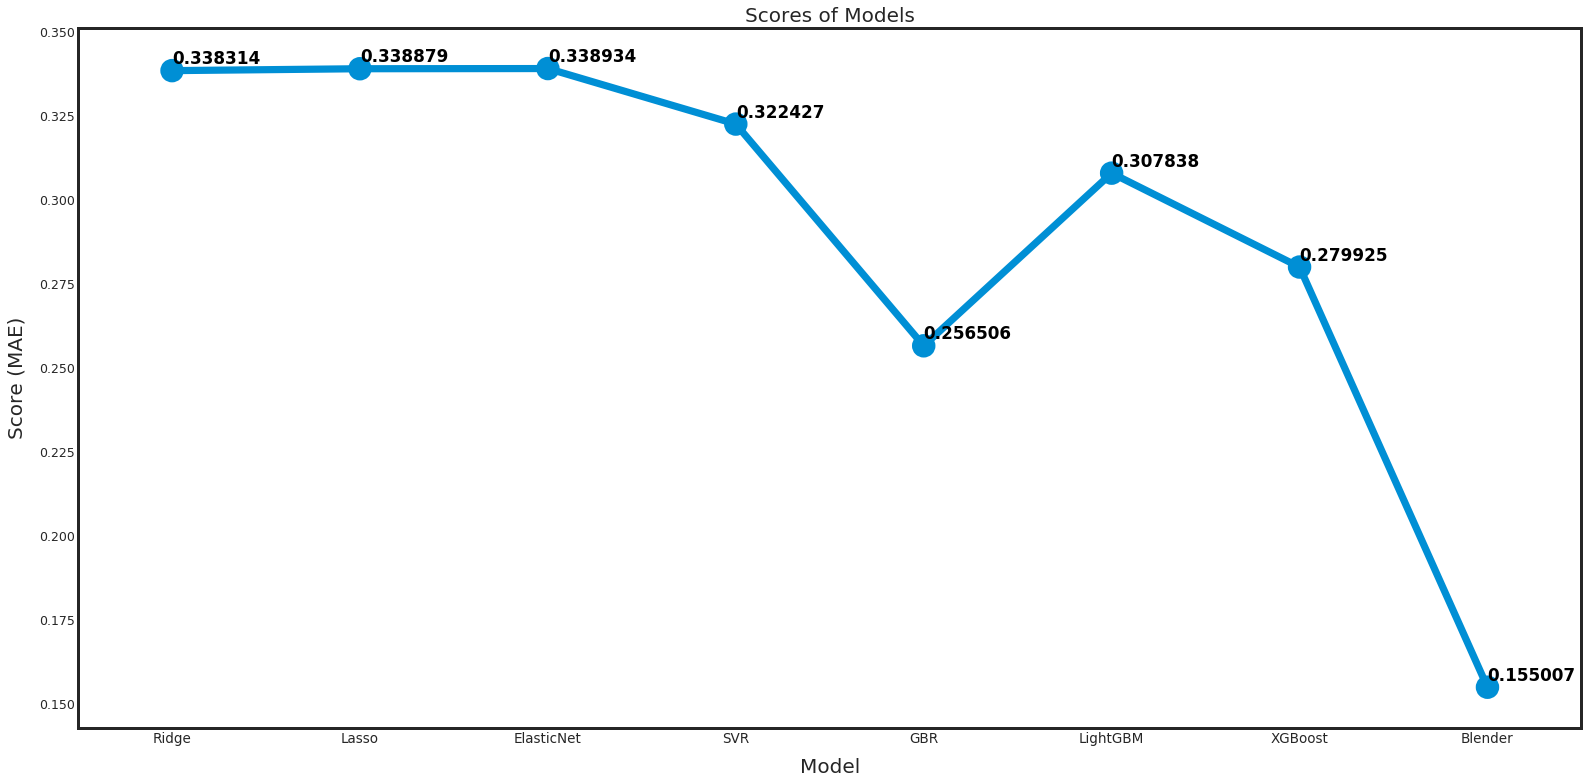

In [151]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

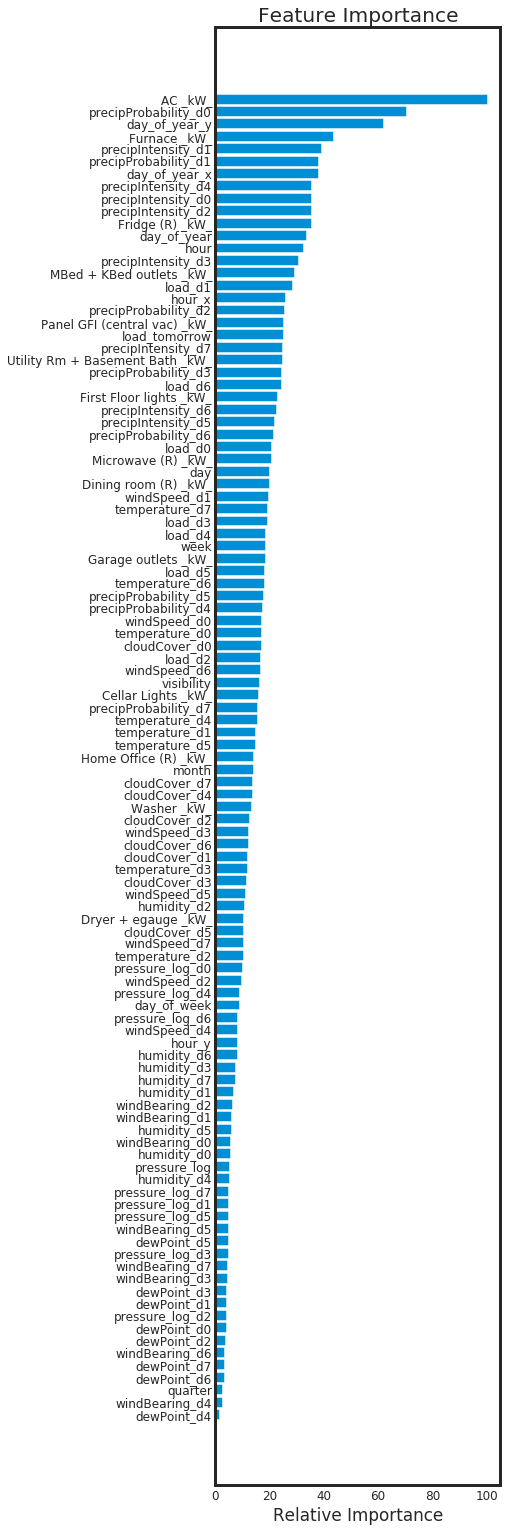

In [154]:
# Plot feature importance
plt.figure(figsize=(10,25))
feature_importance = gbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, lagged_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [165]:
def plot_prediction_multistep(actual, prediction, start_date, title, prediction_label):
    date_rng = pd.date_range(start=start_date, periods=24, freq='H')
    plt.figure(figsize=(30,5))
    plt.title(title)
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, prediction, label=prediction_label)
    plt.ylabel('Power(kW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.show()

In [54]:
import warnings

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'


warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [56]:
def get_features(date, comb_df):
    features = comb_df.loc[date]
    features = (features.assign(day_of_week = features.index.dayofweek,month = features.index.month,day = features.index.day
                                ,day_of_year = features.index.dayofyear,week = features.index.week,quarter = features.index.quarter
                                ,hour = features.index.hour,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.),day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)))
    
    
    for day in range(8):
        features['temperature_d' + str(day)] = comb_df.temperature.shift(24*day)
        features['windSpeed_d' + str(day)] = comb_df.windSpeed.shift(24*day)
        features['humidity_d' + str(day)] = comb_df.humidity.shift(24*day)
        features['pressure_log_d' + str(day)] = comb_df.pressure_log.shift(24*day)
        features['cloudCover_d' + str(day)] = comb_df.cloudCover.shift(24*day)
        features['windBearing_d' + str(day)] = comb_df.windBearing.shift(24*day)
        features['precipIntensity_d' + str(day)] = comb_df.precipIntensity.shift(24*day)
        features['dewPoint_d' + str(day)] = comb_df.dewPoint.shift(24*day)
        features['precipProbability_d' + str(day)] = comb_df.precipProbability.shift(24*day)
        features['load_d' + str(day)] = comb_df['use _kW_'].shift(24*day)

    
    features = features.dropna()
    #print(features)
    
    features = features.drop(columns=['temperature', 'windSpeed', 'humidity', 'pressure', 'cloudCover',
                                    'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability','use _kW_'])

    return features

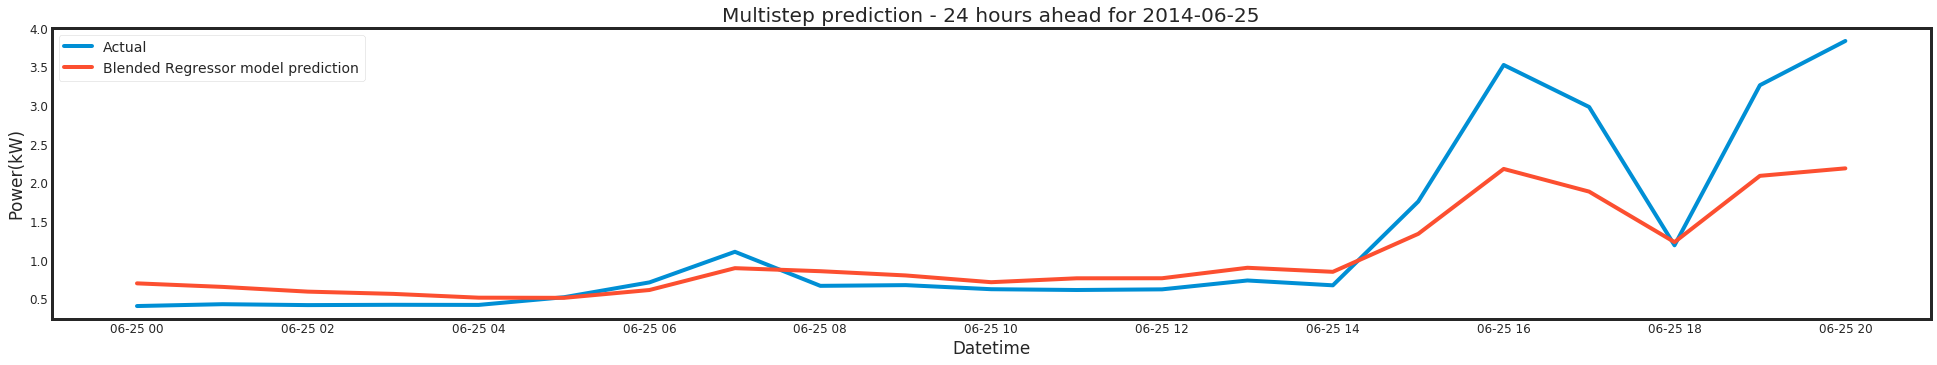

In [177]:
date = '2014-06-25'

prediction = elasticnet.predict(get_features(date, comb_df))

plot_prediction_multistep(actual=comb_df['use _kW_'].loc[date],prediction=prediction, start_date=date, title='Multistep prediction - 24 hours ahead for 2014-06-25',
                prediction_label='Blended Regressor model prediction') 

In [179]:
def plot_prediction(actual, prediction, start_date, end_date, title, prediction_label):
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, prediction, label=prediction_label)
    plt.ylabel('Power(kW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.xlim(left= start_date, right=end_date)
    plt.show()
    
def subplot_prediction(actual, prediction,prediction_label):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 15))
    
    con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)
    axes[0].set_title('Actual vs Prediction - One hour')
    axes[0].set_ylabel('Power(kW)')
    axes[0].set_xlabel('Datetime')
    con_df.plot(ax=axes[0])
    axes[0].set_xlim(left=con_df.index[-1] , right=con_df.index[-1])
    
    con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)
    axes[0].set_title('Actual vs Prediction - One day')
    axes[0].set_ylabel('Power(kW)')
    axes[0].set_xlabel('Datetime')
    con_df.plot(ax=axes[1])
    axes[0].set_xlim(left=con_df.index[-24*1] , right=con_df.index[-1])
    
    axes[1].set_title('Actual vs Prediction - One week')
    axes[1].set_ylabel('Power(kW)')
    axes[1].set_xlabel('Datetime')
    con_df.plot(ax=axes[2])
    axes[1].set_xlim(left=actual.index[-24*7] , right=actual.index[-1])
    
    axes[2].set_title('Actual vs Prediction - One month')
    axes[2].set_ylabel('Power(kW)')
    axes[2].set_xlabel('Datetime')
    con_df.plot(ax=axes[3])
    axes[2].set_xlim(left=actual.index[-24*7*4] , right=actual.index[-1])
    
    plt.tight_layout()
    plt.show()
    
def plot_feature_importances( clf, X_train, y_train=None
                             ,top_n=10, figsize=(10,18), print_table=False, title="Feature Importances"):
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

In [182]:
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [183]:
X = final_df.drop(columns = ['use _kW_'])
y = final_df['use _kW_']

In [184]:
X.shape

(7289, 36)

In [185]:
y.shape

(7289,)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [190]:
print('Building model...')
#kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
tscv = TimeSeriesSplit(n_splits=10)

def rmsle(y, y_pred):
    return mean_absolute_error(y, y_pred)

def cv_rmse(model, X=X):
    rmse = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=tscv)
    return (rmse)

Building model...


In [191]:
#scores = -cross_val_score(reg, X.values, y.values, cv=tscv,scoring='neg_mean_absolute_error')

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=tscv))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=tscv))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=tscv, l1_ratio=e_l1ratio))  

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0004,))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=4, max_features='sqrt', min_samples_leaf=20, min_samples_split=10, loss='huber', random_state =42)                             

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.005, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=4060,
                                     max_depth=4, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00005)

adaboost = AdaBoostRegressor()

extratrees = ExtraTreesRegressor()

bagging = BaggingRegressor()

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm, adaboost, extratrees, bagging),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

#Store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'SVR': svr,
          'GBR': gbr,
          'LightGBM': lightgbm,
          'XGBoost': xgboost,
         'AdaBoost': adaboost,
         'Extratrees': extratrees,
         'Bagging': bagging}
scores = {}

#Evaluating model score
print('Evaluating model scores...')
for name, model in models.items():    
    score = cv_rmse(model)
    print((name + ": {:.4f} ({:.4f})\n").format(score.mean(), score.std()))
    scores[name] = (score.mean(), score.std())
    
print('Done evaluating')

print('Fitting models...')

print('Fitting StackingRegressor...')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

print('Fitting ElasticNet...')
elastic_model_full_data = elasticnet.fit(X_train,y_train)

print('Fitting Lasso...')
lasso_model_full_data = lasso.fit(X_train,y_train)

print('Fitting Ridge...')
ridge_model_full_data = ridge.fit(X_train,y_train)

print('Fitting SVR...')
svr_model_full_data = svr.fit(X_train,y_train)

print('Fitting GradientBoosting...')
gbr_model_full_data = gbr.fit(X_train,y_train)

print('Fitting XGBoost...')
xgb_model_full_data = xgboost.fit(X_train,y_train)

print('Fitting LightGBM...')
lgb_model_full_data = lightgbm.fit(X_train,y_train)

print('Fitting AdaBoost...')
adaboost_model_full_data = adaboost.fit(X_train,y_train)

print('Fitting extratrees...')
extratrees_model_full_data = extratrees.fit(X_train,y_train)

print('Fitting Bagging...')
bagging_model_full_data = bagging.fit(X_train,y_train)

print('Done fitting all models')

Evaluating model scores...
Ridge: 0.2340 (0.1666)

Lasso: 0.2318 (0.1668)

ElasticNet: 0.2333 (0.1683)

SVR: 0.2931 (0.2400)

GBR: 0.1912 (0.1649)

LightGBM: 0.2183 (0.1828)

[22:54:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:29] WARNING: /workspace/src/objective/regression_obj.cu:

Blending model predictions...
MAE score on train data:0.170911867448683


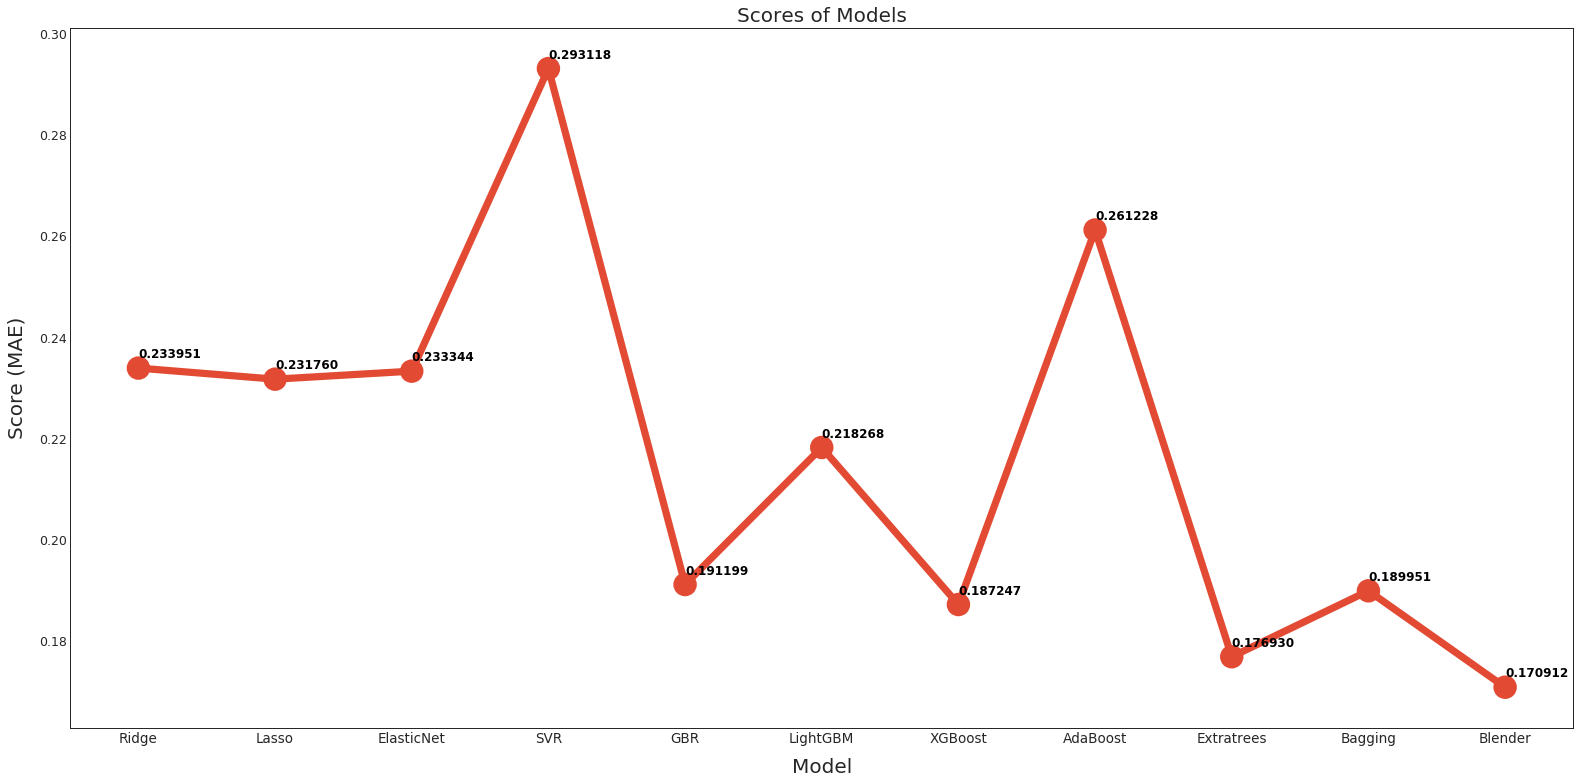

In [210]:
#Blending model predictions
print('Blending model predictions...')
def blend_models_predict(X):
    return ((0.045 * elastic_model_full_data.predict(X))+(0.05 * lasso_model_full_data.predict(X))
            +(0.05 * ridge_model_full_data.predict(X)) + (0.1 * svr_model_full_data.predict(X))
            +(0.15 * gbr_model_full_data.predict(X))+(0.1 * xgb_model_full_data.predict(X))
            +(0.0005 * adaboost_model_full_data.predict(X))+(0.0005 * extratrees_model_full_data.predict(X))
            +(0.0005 * bagging_model_full_data.predict(X))
            +(0.001 * lgb_model_full_data.predict(X))+(0.5 * stack_gen_model.predict(np.array(X))))

rmsle_score = rmsle(y_test, blend_models_predict(X_test))
print('MAE score on train data:' + str(rmsle_score))
scores['Blender'] = (rmsle_score.mean(), rmsle_score.std())

sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

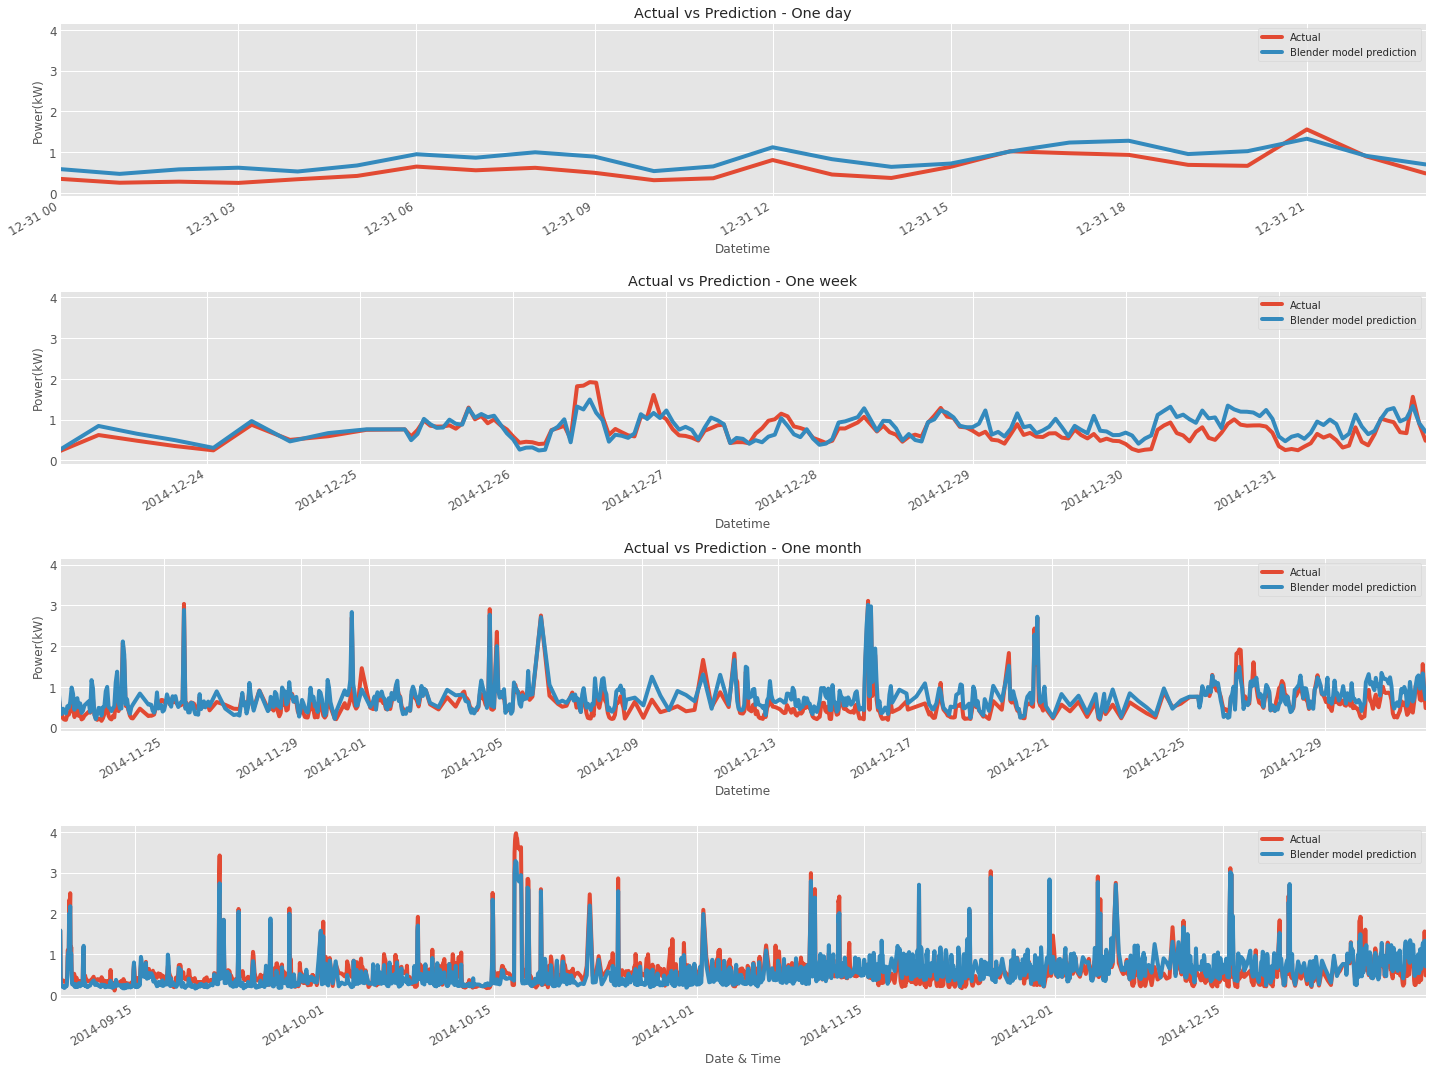

In [211]:
plt.style.use('ggplot')
subplot_prediction(y_test, blend_models_predict(X_test),prediction_label='Blender model prediction')

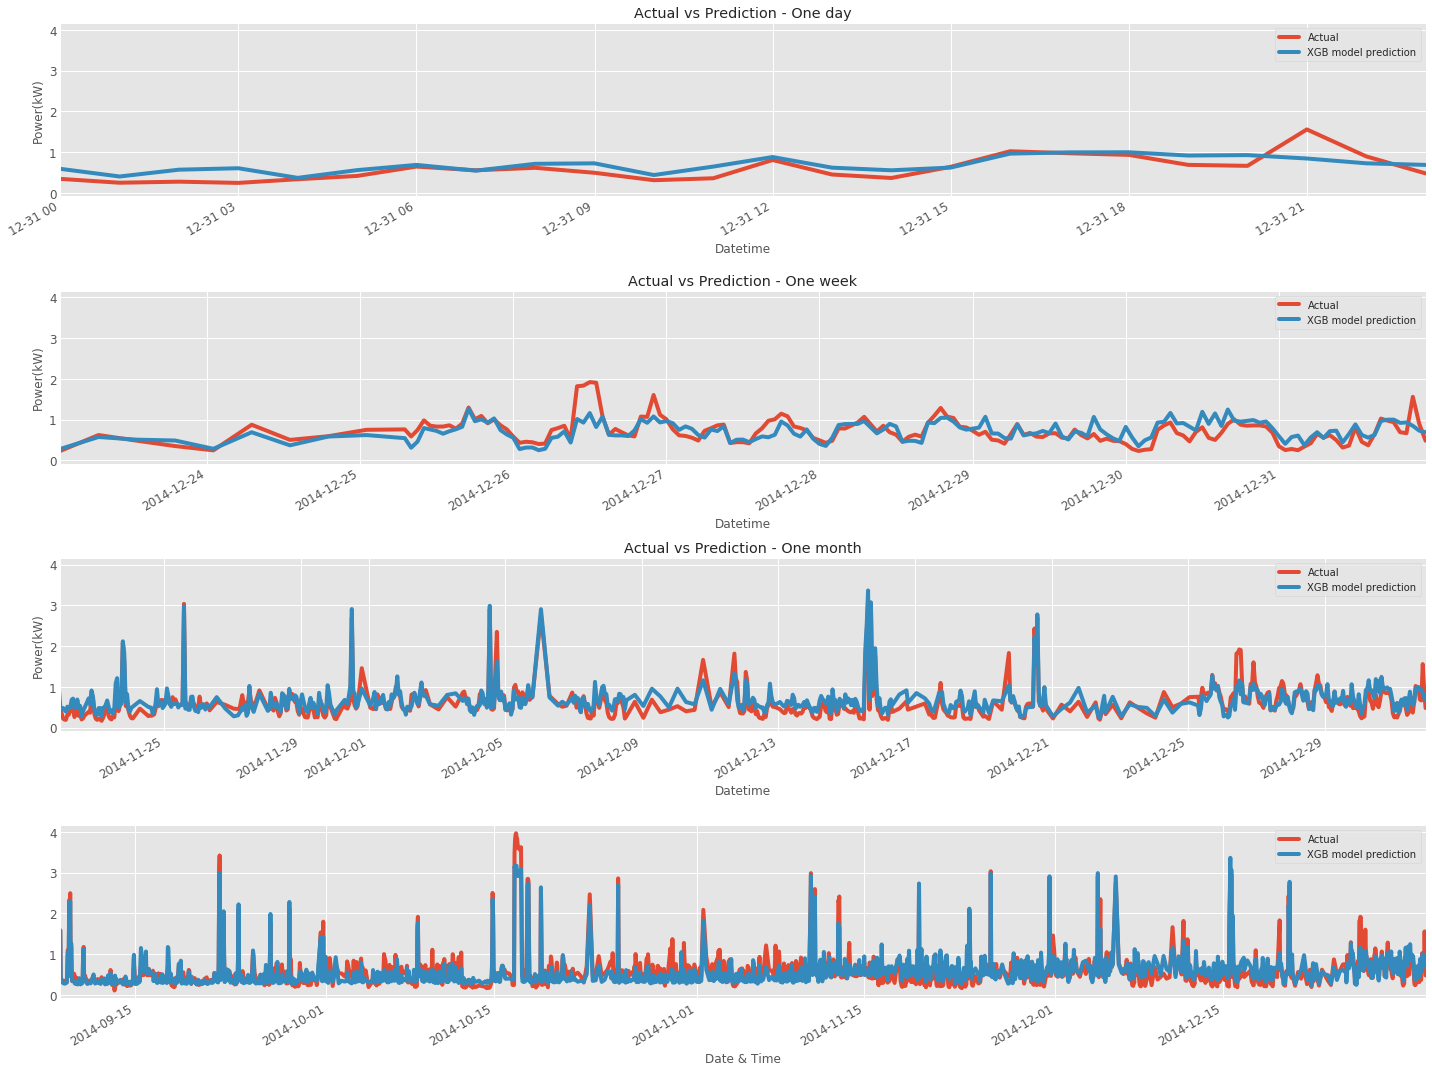

In [189]:
plt.style.use('ggplot')
subplot_prediction(y_test, prediction,prediction_label='XGB model prediction')

In [56]:
reg = AdaBoostRegressor()

In [57]:
tscv = TimeSeriesSplit(n_splits=10)
scores = cross_val_score(reg, X, y, cv=tscv, scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))

Accuracy: -0.25 (+/- 0.11)


In [58]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)

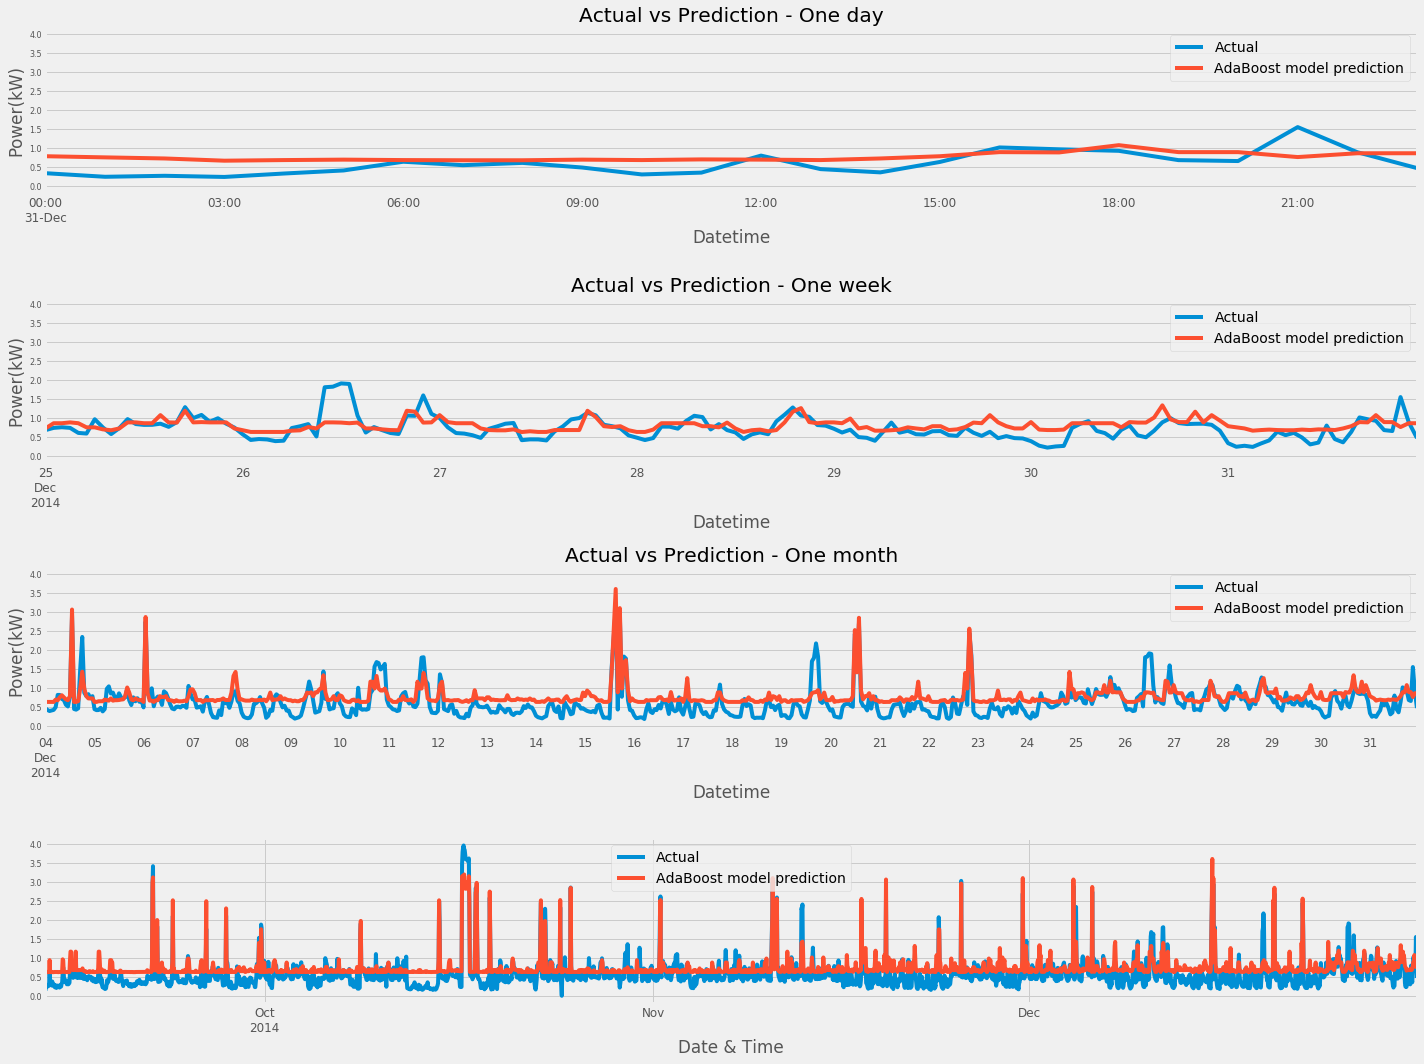

In [61]:
subplot_prediction(y_test, prediction,prediction_label='AdaBoost model prediction')

In [62]:
reg = BaggingRegressor()

In [64]:
tscv = TimeSeriesSplit(n_splits=10)
scores = cross_val_score(reg, X, y, cv=tscv, scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))
print(scores)

Accuracy: -0.19 (+/- 0.17)
[-0.05184583 -0.06781221 -0.0714677  -0.0878542  -0.48332059 -0.18076607
 -0.56385597 -0.13232693 -0.12938362 -0.13324853]


In [65]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)

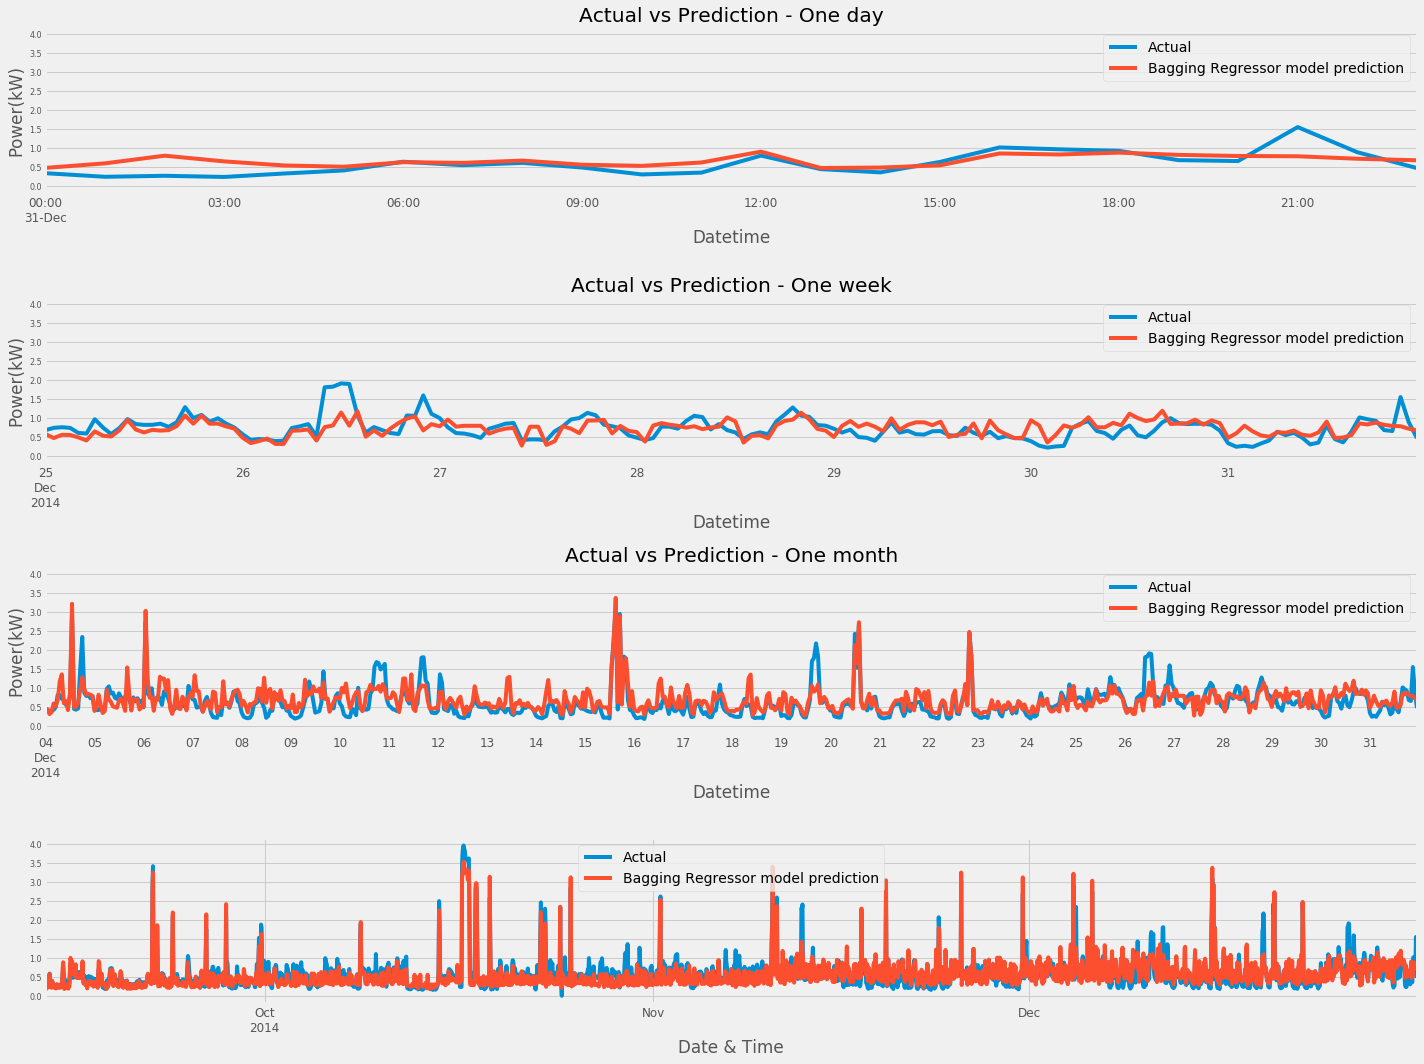

In [66]:
subplot_prediction(y_test, prediction,prediction_label='Bagging Regressor model prediction')

In [67]:
reg = ExtraTreesRegressor()

In [68]:
tscv = TimeSeriesSplit(n_splits=10)
scores = cross_val_score(reg, X, y, cv=tscv, scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))

Accuracy: -0.17 (+/- 0.13)


In [69]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)

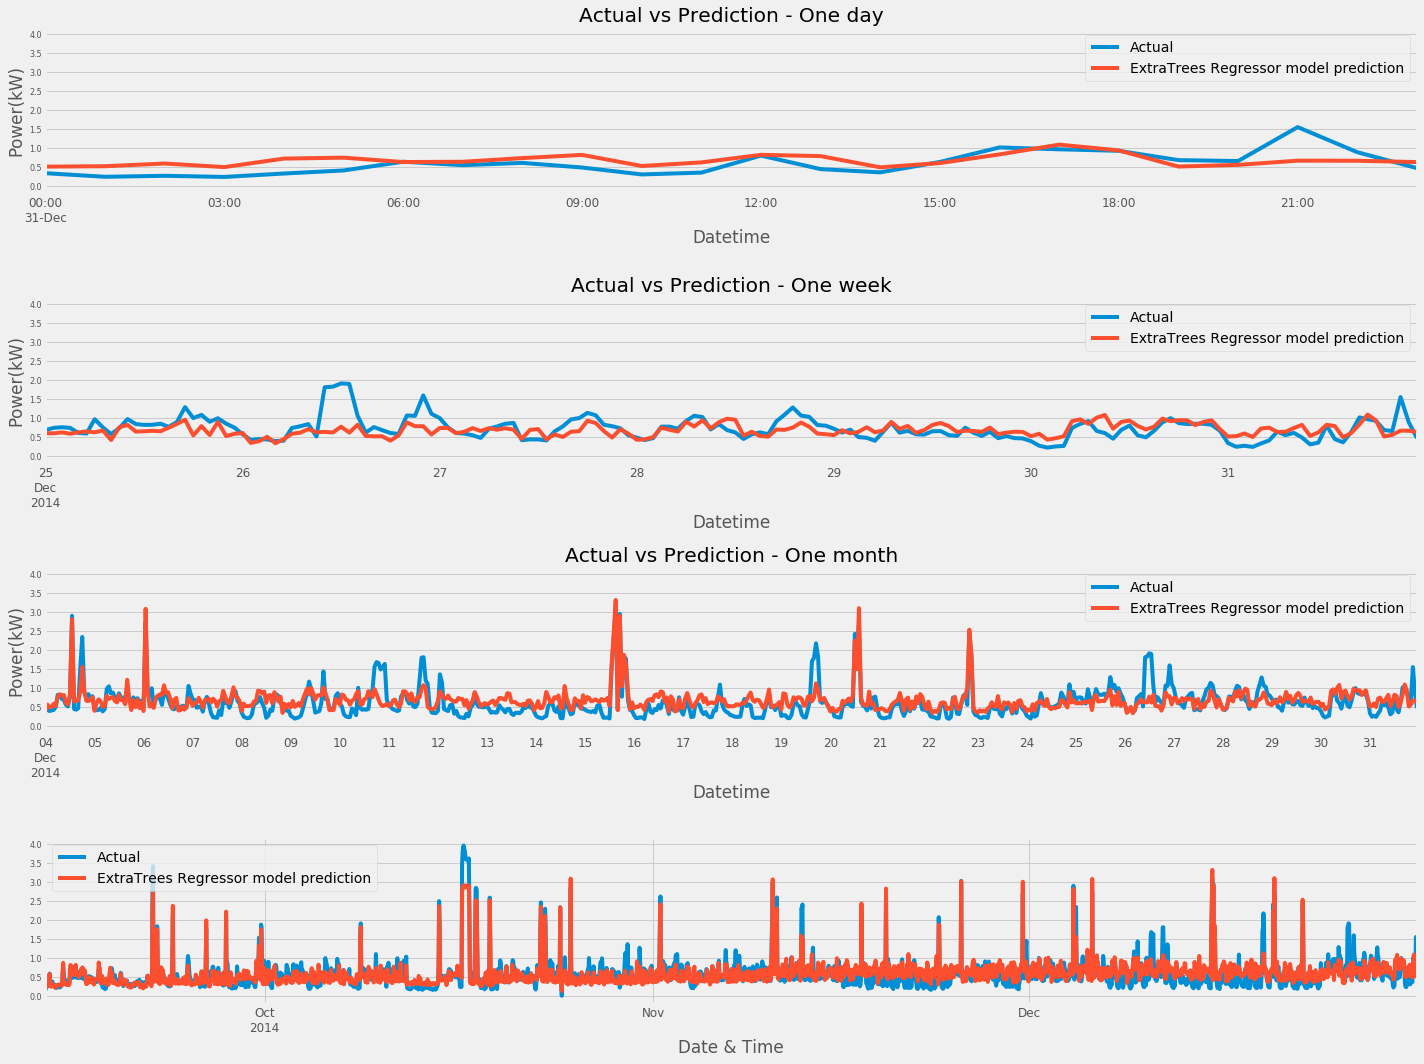

In [71]:
subplot_prediction(y_test, prediction,prediction_label='ExtraTrees Regressor model prediction')